# Simulation of an optical transmission with single-ended receiver

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

from commpy.modulation import QAMModem

from optic.core import parameters
from optic.tx import simpleWDMTx
from optic.plot import pconst

from optic.models import pdmSEReceiver, linFiberCh, phaseNoise, awgn

from optic.dsp import pulseShape, firFilter, decimate, symbolSync
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power, calcEVM

import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')

### Transmitter (dual-polarization)

  0%|          | 0/1 [00:00<?, ?it/s]

channel 0	 fc : 193.1000 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm


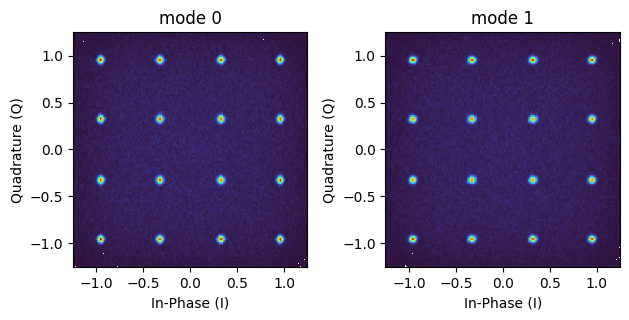

(<Figure size 640x480 with 2 Axes>,
 <ScatterDensityAxes: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [16]:
# Parameters - transmitter
paramTx = parameters()

paramTx.M   = 16           # order of the modulation format
paramTx.constType = 'qam'   # modulation format

paramTx.Rs  = 100e9         # symbol rate [baud]
paramTx.SpS = 4             # samples per symbol
Fs = paramTx.Rs*paramTx.SpS # sampling rate

paramTx.Nbits = 300000      # total number of bits per polarization

paramTx.pulse    = 'rrc'    # pulse shaping filter
paramTx.Ntaps    = 1024     # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01     # RRC rolloff

paramTx.Pch_dBm  = 0        # power per WDM channel [dBm]
paramTx.Nch      = 1        # number of WDM channels

paramTx.Fc     = 193.1e12   # central optical frequency of the WDM spectrum
paramTx.Nmodes = 2          # number of signal modes [2 for polarization multiplexed signals]


sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)
pconst(sigWDM_Tx)

### Linear fiber propagation with ideal amplification

In [17]:
# Parameters - optical channel
paramCh = parameters()

paramCh.Ltotal = 160       # total link distance [km] 
paramCh.alpha = 0          # fiber loss parameter [dB/km] (ideal amplification)
paramCh.D = 16             # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = paramTx.Fc    # central optical frequency of the WDM spectrum
paramCh.Fs = Fs            # sampling rate

sigWDM = linFiberCh(sigWDM_Tx, paramCh.Ltotal, paramCh.alpha, paramCh.D, paramCh.Fc, paramCh.Fs)

In [18]:
# Received signal power [dBm]
try: # dual-pol
    potRx  = 10*np.log10( 1e3 * (signal_power(sigWDM[:,0]) + signal_power(sigWDM[:,1])) )
except: # single-pol
    potRx  = 10*np.log10( 1e3 * signal_power(sigWDM))
print(f'Power of received signal: {potRx:.2f} dBm')

Power of received signal: -0.00 dBm


In [19]:
# Additive white Gaussian noise
OSNRdB = 36    # Optical-SNR (OSNR)
SNRdB  = OSNRdB - 10 * np.log10( (paramTx.Rs * paramTx.Nmodes) / (2 * 12.5e9) )
sigWDM = awgn( sigWDM, SNRdB, Fs, paramTx.Rs)

# Received signal power + noise power [dBm]
try: # dual-pol
    potRx_awgn  = 10*np.log10( 1e3 * (signal_power(sigWDM[:,0]) + signal_power(sigWDM[:,1])) )
except: # single-pol
    potRx_awgn  = 10*np.log10( 1e3 * signal_power(sigWDM) )
print(f'Power of received signal + Noise power: {potRx_awgn:.4f} dBm')

Power of received signal + Noise power: 0.0357 dBm


### Optical WDM spectrum before and after transmission

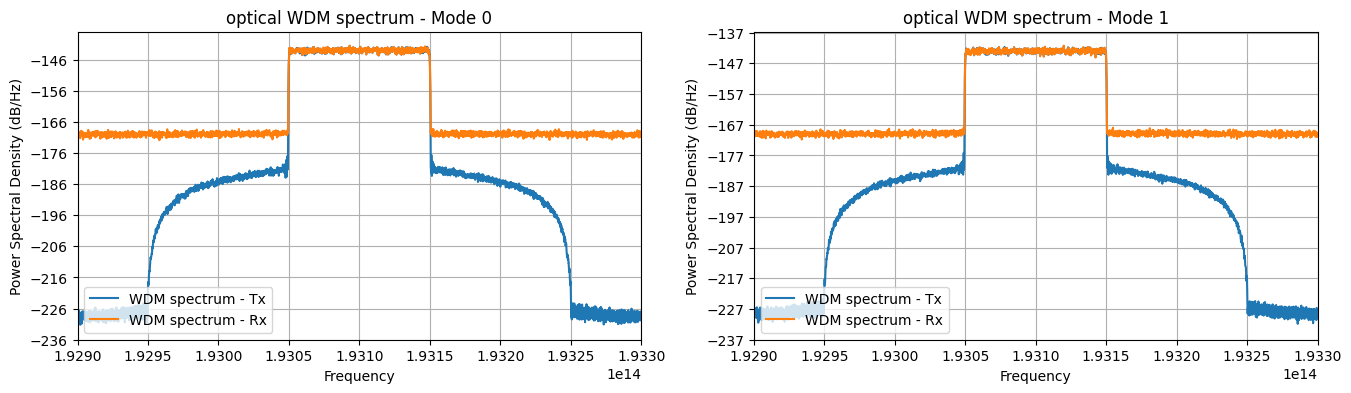

In [20]:
# plot psd
fig, axs = plt.subplots(1, 2, figsize=(16,4))

axs[0].psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
axs[0].psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
axs[0].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2)
axs[0].legend(loc='lower left')
axs[0].set_title('optical WDM spectrum - Mode 0')
axs[0].grid('True')

axs[1].psd(sigWDM_Tx[:,1], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
axs[1].psd(sigWDM[:,1], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
axs[1].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2)
axs[1].legend(loc='lower left')
axs[1].set_title('optical WDM spectrum - Mode 1')
axs[1].grid('True')

### Demodulation (generate LO field)

In [21]:
#############################################
# Parameters - Receiver
mod = QAMModem(m=paramTx.M)

chIndex  = 0     # index of the channel to be demodulated
Fc = paramTx.Fc
Ts = 1/Fs

freqGrid = paramTx.freqGrid
print(f'Demodulating channel #{chIndex} \n',
      f'- fc: {((Fc + freqGrid[chIndex])/1e12):.4f} THz\n',
      f'- λ: {(const.c/(Fc + freqGrid[chIndex])/1e-9):.4f} nm\n')

symbTx = symbTx_[:,:,chIndex]

#############################################
# Parameters - Receiver - local oscillator (LO)
LOSPR   = 8                     # LO-to-signal-power ratio [dB]

π       = np.pi
FO      = 0*64e6                # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 0*100e3               # linewidth
Plo_dBm = potRx + LOSPR         # power [dBm]
Plo     = 10**(Plo_dBm/10)*1e-3 # power [W]
ϕ_lo    = 0                     # initial phase in rad   

print(f'Local oscillator\n',
      f'- Power: {Plo_dBm:.2f} dBm\n',
      f'- LOSPR: {LOSPR:.2f} dBm\n',
      f'- LineWidth: {(lw/1e3):.2f} kHz\n',
      f'- Frequency offset: {(FO/1e6):.2f} MHz')

#############################################
# generate LO field
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

Demodulating channel #0 
 - fc: 193.1000 THz
 - λ: 1552.5244 nm

Local oscillator
 - Power: 8.00 dBm
 - LOSPR: 8.00 dBm
 - LineWidth: 0.00 kHz
 - Frequency offset: 0.00 MHz


### Coherent detection with SER and signal-signal beat interference mitigation

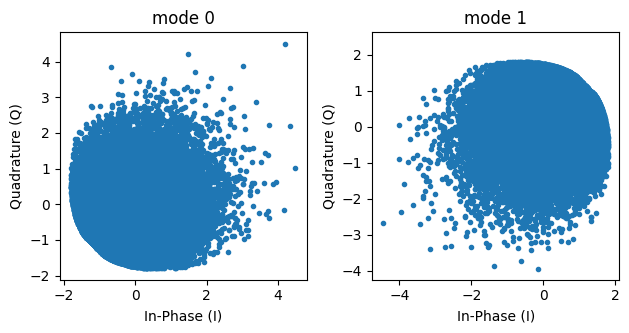

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [22]:
# single-ended receiver
paramPD = parameters()
paramPD.B = 2 * paramTx.Rs
paramPD.Fs = Fs
paramPD.ideal = True

paramEqSSBI = parameters()
paramEqSSBI.alg = "ic"
paramEqSSBI.Nsteps = 20
paramEqSSBI.enableClip = True

θsig = 0 # polarization rotation angle
sigRx = pdmSEReceiver(sigWDM, sigLO, θsig, paramPD, paramEqSSBI)

# plot constellations after coherent receiver and ssbi mitigation
pconst(sigRx[0::paramTx.SpS, :], lim=False, R=3, pType='fast')

### Matched filtering and CD compensation

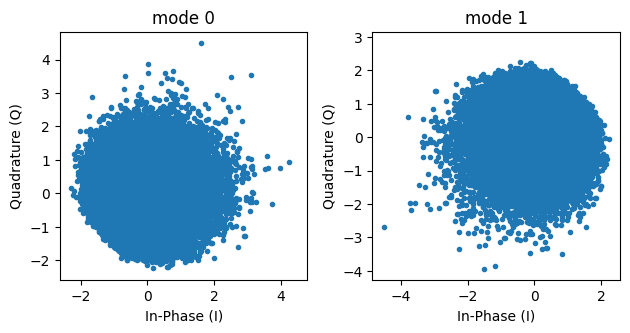

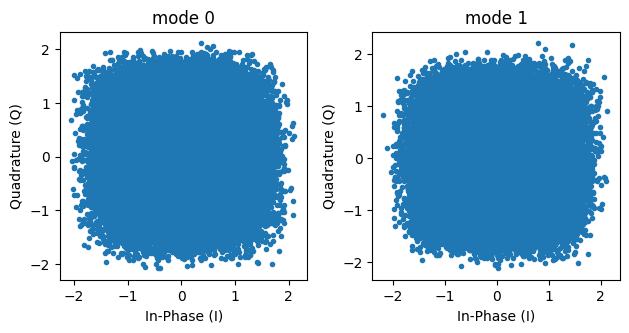

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [23]:
# Rx filtering

# Matched filtering
pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
pulse = pulse/np.max(np.abs(pulse))

sigRx = firFilter(pulse, sigRx)
    
# plot constellations after matched filtering
pconst(sigRx[0::paramTx.SpS,:], lim=False, R=3, pType='fast')

# CD compensation
sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fs)

# plot constellations after CD compensation
pconst(sigRx[0::paramTx.SpS,:], lim=False, R=3, pType='fast')

### Downsampling to 2 SpS and re-synchronization with transmitted sequences

In [24]:
# decimation
paramDec = parameters()

paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2

sigRx = decimate(sigRx, paramDec)
symbRx = symbolSync(sigRx, symbTx, 2)

### Power normalization

In [25]:
x = sigRx
d = symbRx

x = x.reshape(len(x),2)/np.sqrt(signal_power(x))
d = d.reshape(len(d),2)/np.sqrt(signal_power(d))

### Adaptive equalization

nlms - training stage #0
nlms pre-convergence training iteration #0
nlms MSE = 0.008605.
nlms pre-convergence training iteration #1
nlms MSE = 0.008604.
nlms pre-convergence training iteration #2
nlms MSE = 0.008604.
nlms pre-convergence training iteration #3
nlms MSE = 0.008604.
nlms pre-convergence training iteration #4
nlms MSE = 0.008604.
da-rde - training stage #1
da-rde MSE = 0.021548.


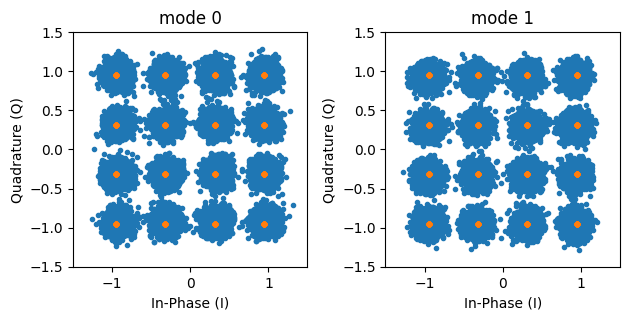

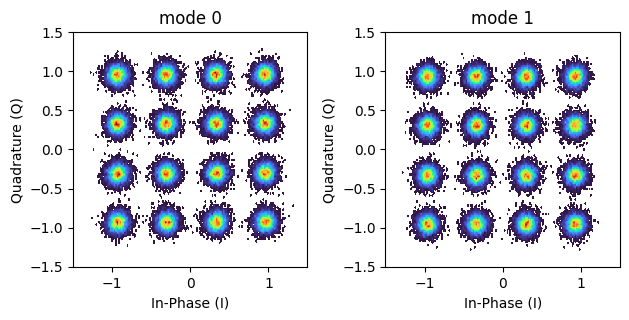

(<Figure size 640x480 with 2 Axes>,
 <ScatterDensityAxes: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [26]:
# adaptive equalization parameters
paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS   = 2
paramEq.mu    = [3e-3, 4e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg   = ['nlms','da-rde']
paramEq.M     = paramTx.M
paramEq.L = [int(0.20*len(x)/2), int(0.80*len(x)/2)]

paramEq.prgsBar = False
y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

# plot constellations after equalization
discard = 5000
pconst([y_EQ[discard:-discard,:],d[discard:-discard,:]], R=1.5, pType='fast')
pconst(y_EQ[discard:-discard,:], R=1.5)

### Carrier phase recovery (CPR)

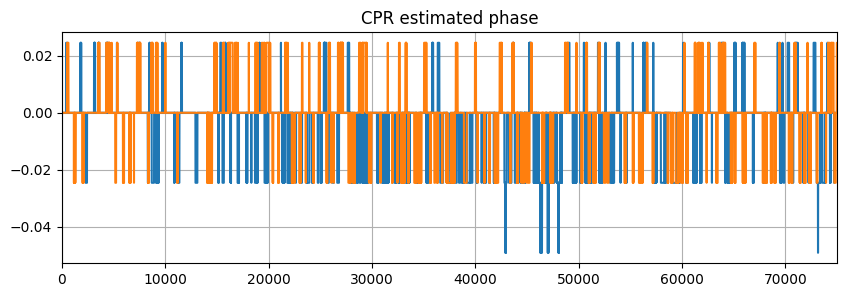

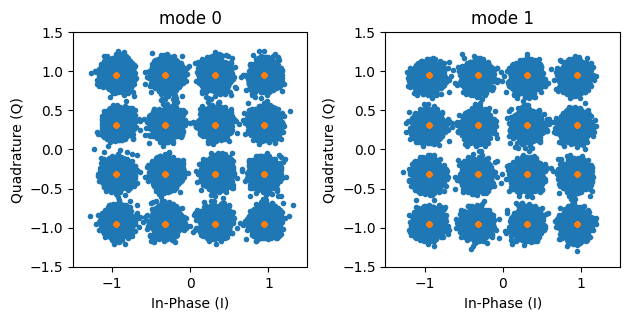

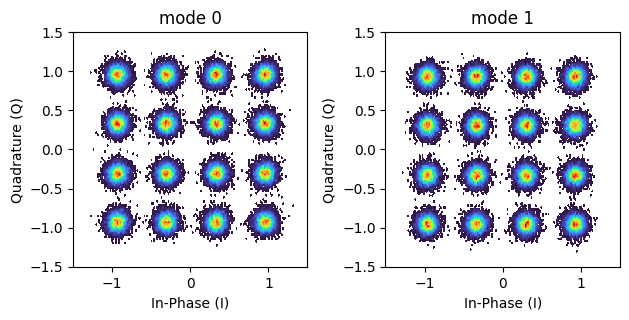

(<Figure size 640x480 with 2 Axes>,
 <ScatterDensityAxes: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [27]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 160
paramCPR.B   = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)
y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure(figsize=(10, 3))
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid()

# plot constellations after CPR
discard = 5000
pconst([y_CPR[discard:-discard,:],d[discard:-discard,:]], R=1.5, pType='fast')
pconst(y_CPR[discard:-discard,:], R=1.5)

### Evaluate transmission metrics

In [28]:
ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))

      pol.X      pol.Y      
 SER: 2.62e-04,  2.62e-04
 BER: 6.54e-05,  6.54e-05
 SNR: 19.76 dB,  19.86 dB
 EVM: 1.06 %,    1.04 %
  MI: 4.00 bits, 4.00 bits
 GMI: 4.00 bits, 4.00 bits
NGMI: 1.00,      1.00
